# Fitting a gyro relation to Praesepe.

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as sco
import scipy.misc as spm

plotpar = {'axes.labelsize': 40,
           'font.size': 30,
           'legend.fontsize': 30,
           'xtick.labelsize': 40,
           'ytick.labelsize': 40,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the Praesepe data.

In [146]:
pr = pd.read_csv("data/praesepe.csv")
m = pr.prot > 0
m &= np.log10(pr.bp[m] - pr.rp[m]) < max(np.log10(pr.bp[m] - pr.rp[m]))

logbprp = np.log10(pr.bp[m] - pr.rp[m])
bprp = pr.bp[m] - pr.rp[m]
# logbprp = (pr.bp[m] - pr.rp[m])

logp = np.log10(pr.prot[m])
err = .434 * .1
logp_err = err * np.ones_like(logp)
log_age = np.ones(len(logp))*np.log10(650*1e6)
subcut = 450
eep = np.random.uniform(200, subcut, len(logp))

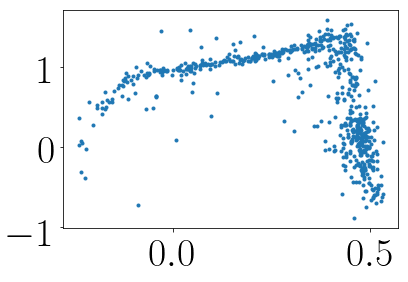

In [147]:
plt.plot(logbprp, logp, ".")

In [148]:
log_age = np.ones(len(logp))*np.log10(650*1e6)

Add the Sun.

In [149]:
sun_age, sun_prot, sun_color = np.array([np.log10(4.56*1e9)]), np.array([np.log10(26)]), np.array([np.log10(.82)])
sun_err, sun_eep = np.array([.0001]), np.array([355])

logbprp_sun = np.concatenate((logbprp, sun_color))
logp_sun = np.concatenate((logp, sun_prot))
log_age_sun = np.concatenate((log_age, sun_age))
logp_err_sun = np.concatenate((logp_err, sun_err))
eep_sun = np.concatenate((eep, sun_eep))

Fit a broken power law to the data.

In [150]:
def bpl_model(p, logbprp, logage, br=.43):
    logp = np.zeros(len(logbprp))
    cool = logbprp >= br
    hot = logbprp < -.25
    warm = (logbprp > -.25) * (logbprp <= br)
    logp[warm] = np.polyval(p[:5], logbprp[warm]) + p[5]*logage[warm]
    logp[cool] = np.polyval(p[6:], logbprp[cool]) + p[5]*logage[cool]
    logp[hot] = np.ones(len(logbprp[hot]))*0
    return logp

def bpl_nll(p, logbprp, logage, logp, logp_err):
    mod = bpl_model(p, logbprp, logage)
    var = logp_err**2
    return - np.sum(-.5 * (mod - logp)**2/var - .5*np.log(2*np.pi*var))

def bpl_lnlike(p, logbprp, logage, logp, logp_err):
    mod = bpl_model(p, logbprp, logage)
    var = logp_err**2
    return np.sum(-.5 * (mod - logp)**2/var - .5*np.log(2*np.pi*var))

In [151]:
p0_bpl = np.ones(8)
bpl_result = sco.minimize(bpr_nll, p0_bpl, args=(logbprp_sun, log_age_sun, logp_sun, np.ones_like(logp_sun)*.1))
print("parameters = ", list(bpl_result.x))

parameters =  [-78.28974014954993, 33.03040623820474, -2.2672595564004903, 0.6812268828606771, -5.147626160298859, 0.6898497084797756, -13.558904758485177, 0.5591352677414279]


Plot the fit.

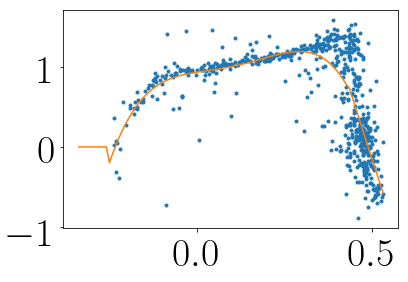

In [152]:
plt.plot(logbprp_sun, logp_sun, ".")
xplot = np.linspace(min(logbprp_sun) - .1, max(logbprp_sun), 100)
plt.plot(xplot, bpl_model(bpl_result.x, xplot, np.ones_like(xplot)*np.log10(650*1e6)))

This fit would be significantly improved with some sigma clipping!

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


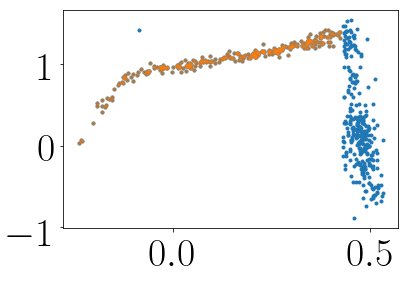

In [153]:
def sigma_clip(x, y, yerr, sig=4, iterations=10):
    finite_mask = np.isfinite(x) * np.isfinite(y)
    x, y, yerr = x[finite_mask], y[finite_mask], yerr[finite_mask]
    new_x, new_y, new_yerr = x*1, y*1, yerr*1
    
    for i in range(iterations):
        A = np.vander(new_x, 6)
        ATA = np.dot(A.T, A)
        pr = np.linalg.solve(ATA, np.dot(A.T, new_y))
        y_pred = np.polyval(pr, new_x)
        sigma = np.std(np.abs(new_y - y_pred))
        outlier_mask = np.abs(new_y - y_pred) < sig*sigma
        new_x, new_y, new_yerr = new_x[outlier_mask], new_y[outlier_mask], new_yerr[outlier_mask]
    
    return new_x, new_y, new_yerr

hot_mask = logbprp < .43
x_clipped, y_clipped, yerr_clipped = sigma_clip(logbprp[hot_mask], logp[hot_mask], logp_err[hot_mask],
                                               iterations=20)

ncool, nhot = len(logbprp[~hot_mask]), len(x_clipped)
p_age = np.log10(650*1e6)
logbprp_clipped = np.concatenate((logbprp[~hot_mask], x_clipped, sun_color))
logp_clipped = np.concatenate((logp[~hot_mask], y_clipped, sun_prot))
logp_err_clipped = np.concatenate((logp_err[~hot_mask], yerr_clipped, np.array([.00001])))
log_age_clipped = np.concatenate((np.ones(len(logbprp[~hot_mask]))*p_age, np.ones(len(x_clipped))*p_age, sun_age))

plt.plot(logbprp_clipped, logp_clipped, ".")
plt.plot(x_clipped, y_clipped, ".", alpha=.5)

In [154]:
bpl_result = sco.minimize(bpl_nll, p0_bpl, args=(logbprp_clipped, 
                                                 log_age_clipped, logp_clipped, 
                                                 np.ones_like(logp_clipped)*.1*.434))
print("parameters = ", list(bpl_result.x))

parameters =  [-38.96093821359645, 28.71101008315462, -4.91903824593666, 0.7160561986000329, -4.716546365981507, 0.6470642123725334, -13.55890448246179, 0.9361999874258322]


Now use MCMC

In [ ]:
import emcee

ndim, nwalkers = len(bpl_result.x), 32
pos = [bpl_result.x + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, bpl_lnlike, args=(logbprp_clipped, log_age_clipped, logp_clipped, 
                                      np.ones_like(logp_clipped)*.1*.434));
print("Burn-in")
pos, lp, state = sampler.run_mcmc(pos, 1000);
sampler.reset();
print("Full Run")
sampler.run_mcmc(pos, 5000);

Burn-in
Full Run


In [ ]:
import corner
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

pnames = ["e", "d", "c", "b", "a", "f", "h", "g"]
fig = corner.corner(samples, labels=pnames);
mcmc_results = np.median(samples, axis=0)

In [76]:
print("Warm star model = a + bC + cC**2 + dC**3 + eC**4 + fA")
print("Cool star model = g + hC + fA")
for i, param in enumerate(mcmc_results):
    errp = np.percentile(samples[:, i], 84) - param
    errm = param - np.percentile(samples[:, i], 16)
    std = np.std(samples[:, i])
#     print(pnames[i], "=", param, "+", errp, "-", errm)
    print(pnames[i], "=", param, "+/-", std)

Warm star model = a + bC + cC**2 + dC**3 + eC**4 + fA
Cool star model = g + hC + fA
e = -38.910901216040415 +/- 3.3450690588169283
d = 28.69679400438059 +/- 1.5216257843001764
c = -4.922821234194197 +/- 0.21291153642513447
b = 0.7161892751575165 +/- 0.058795643177902604
a = -4.728988077557984 +/- 0.4641211932857189
f = 0.6485448695163021 +/- 0.052620611124516964
h = -13.558434380861339 +/- 0.1041135580860455
g = 0.9236229091248385 +/- 0.4668859013238853


Text(0, 0.5, '$\\sigma$')

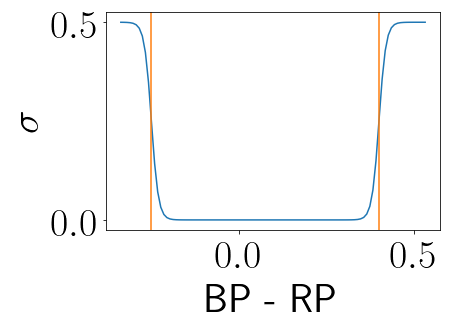

In [79]:
k = 100

def sigmoid(k, x0, L, x):
    return L/(np.exp(-k*(x - x0)) + 1)

sigma = sigmoid(k, .4, .5, xplot) + sigmoid(k, .25, .5, -xplot)

plt.plot(xplot, sigma)
plt.axvline(.4, color="C1")
plt.axvline(-.25, color="C1")

plt.xlabel("BP - RP")
plt.ylabel("$\sigma$")

# def sigmoid_variance(bprp, eep):
#     return sigmoid(k, .4, xplot) + sigmoid(k, .25, -xplot)

Text(0, 0.5, '$\\sigma$')

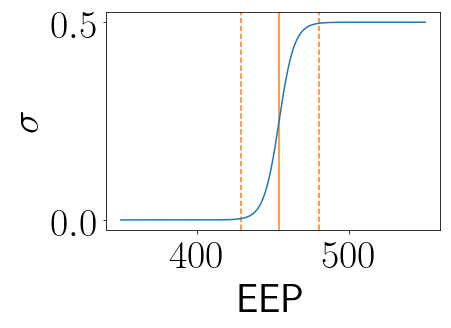

In [81]:
eep_plot = np.linspace(350, 550, 1000)
sigma_eep = sigmoid(.2, 454, .5, eep_plot)
plt.axvline(454, color="C1")
plt.axvline(429, color="C1", ls="--")
plt.axvline(480, color="C1", ls="--")
plt.plot(eep_plot, sigma_eep)
plt.xlabel("EEP")
plt.ylabel("$\sigma$")

Text(0, 0.5, '$\\sigma$')

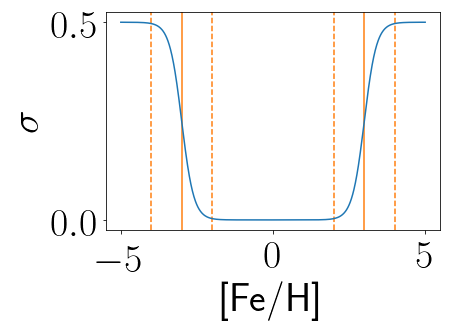

In [95]:
feh_plot = np.linspace(-5, 5, 1000)
k_feh = 5
L_feh = .5
x0_feh = 3.
sigma_feh = sigmoid(k_feh, x0_feh, L_feh, feh_plot) + sigmoid(k_feh, x0_feh, L_feh, -feh_plot)

plt.axvline(x0_feh, color="C1")
plt.axvline(2, color="C1", ls="--")
plt.axvline(4, color="C1", ls="--")
plt.axvline(-2, color="C1", ls="--")
plt.axvline(-4, color="C1", ls="--")
plt.axvline(-x0_feh, color="C1")
plt.plot(feh_plot, sigma_feh)
plt.xlabel("[Fe/H]")
plt.ylabel("$\sigma$")

Text(0, 0.5, '$\\sigma$')

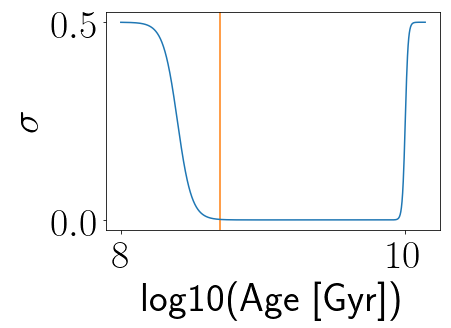

In [134]:
age_plot = np.linspace(8, 10.14, 1000)
k_age = 100
k_young = 20
L_age = .5
x0_age = np.log10(10*1e9)
x0_young = np.log10(250*1e6)
sigma_age = sigmoid(k_age, x0_age, L_age, age_plot) + sigmoid(k_young, -x0_young, L_age, -age_plot)

# plt.axvline(10, color="C1")
# plt.axvline(8.5, color="C1", ls="--")
# plt.axvline(11.5, color="C1", ls="--")
# plt.plot((10**age_plot)*1e-9, sigma_age)
plt.axvline(np.log10(500*1e6), color="C1")
plt.plot(age_plot, sigma_age)
plt.xlabel("log10(Age [Gyr])")
plt.ylabel("$\sigma$")

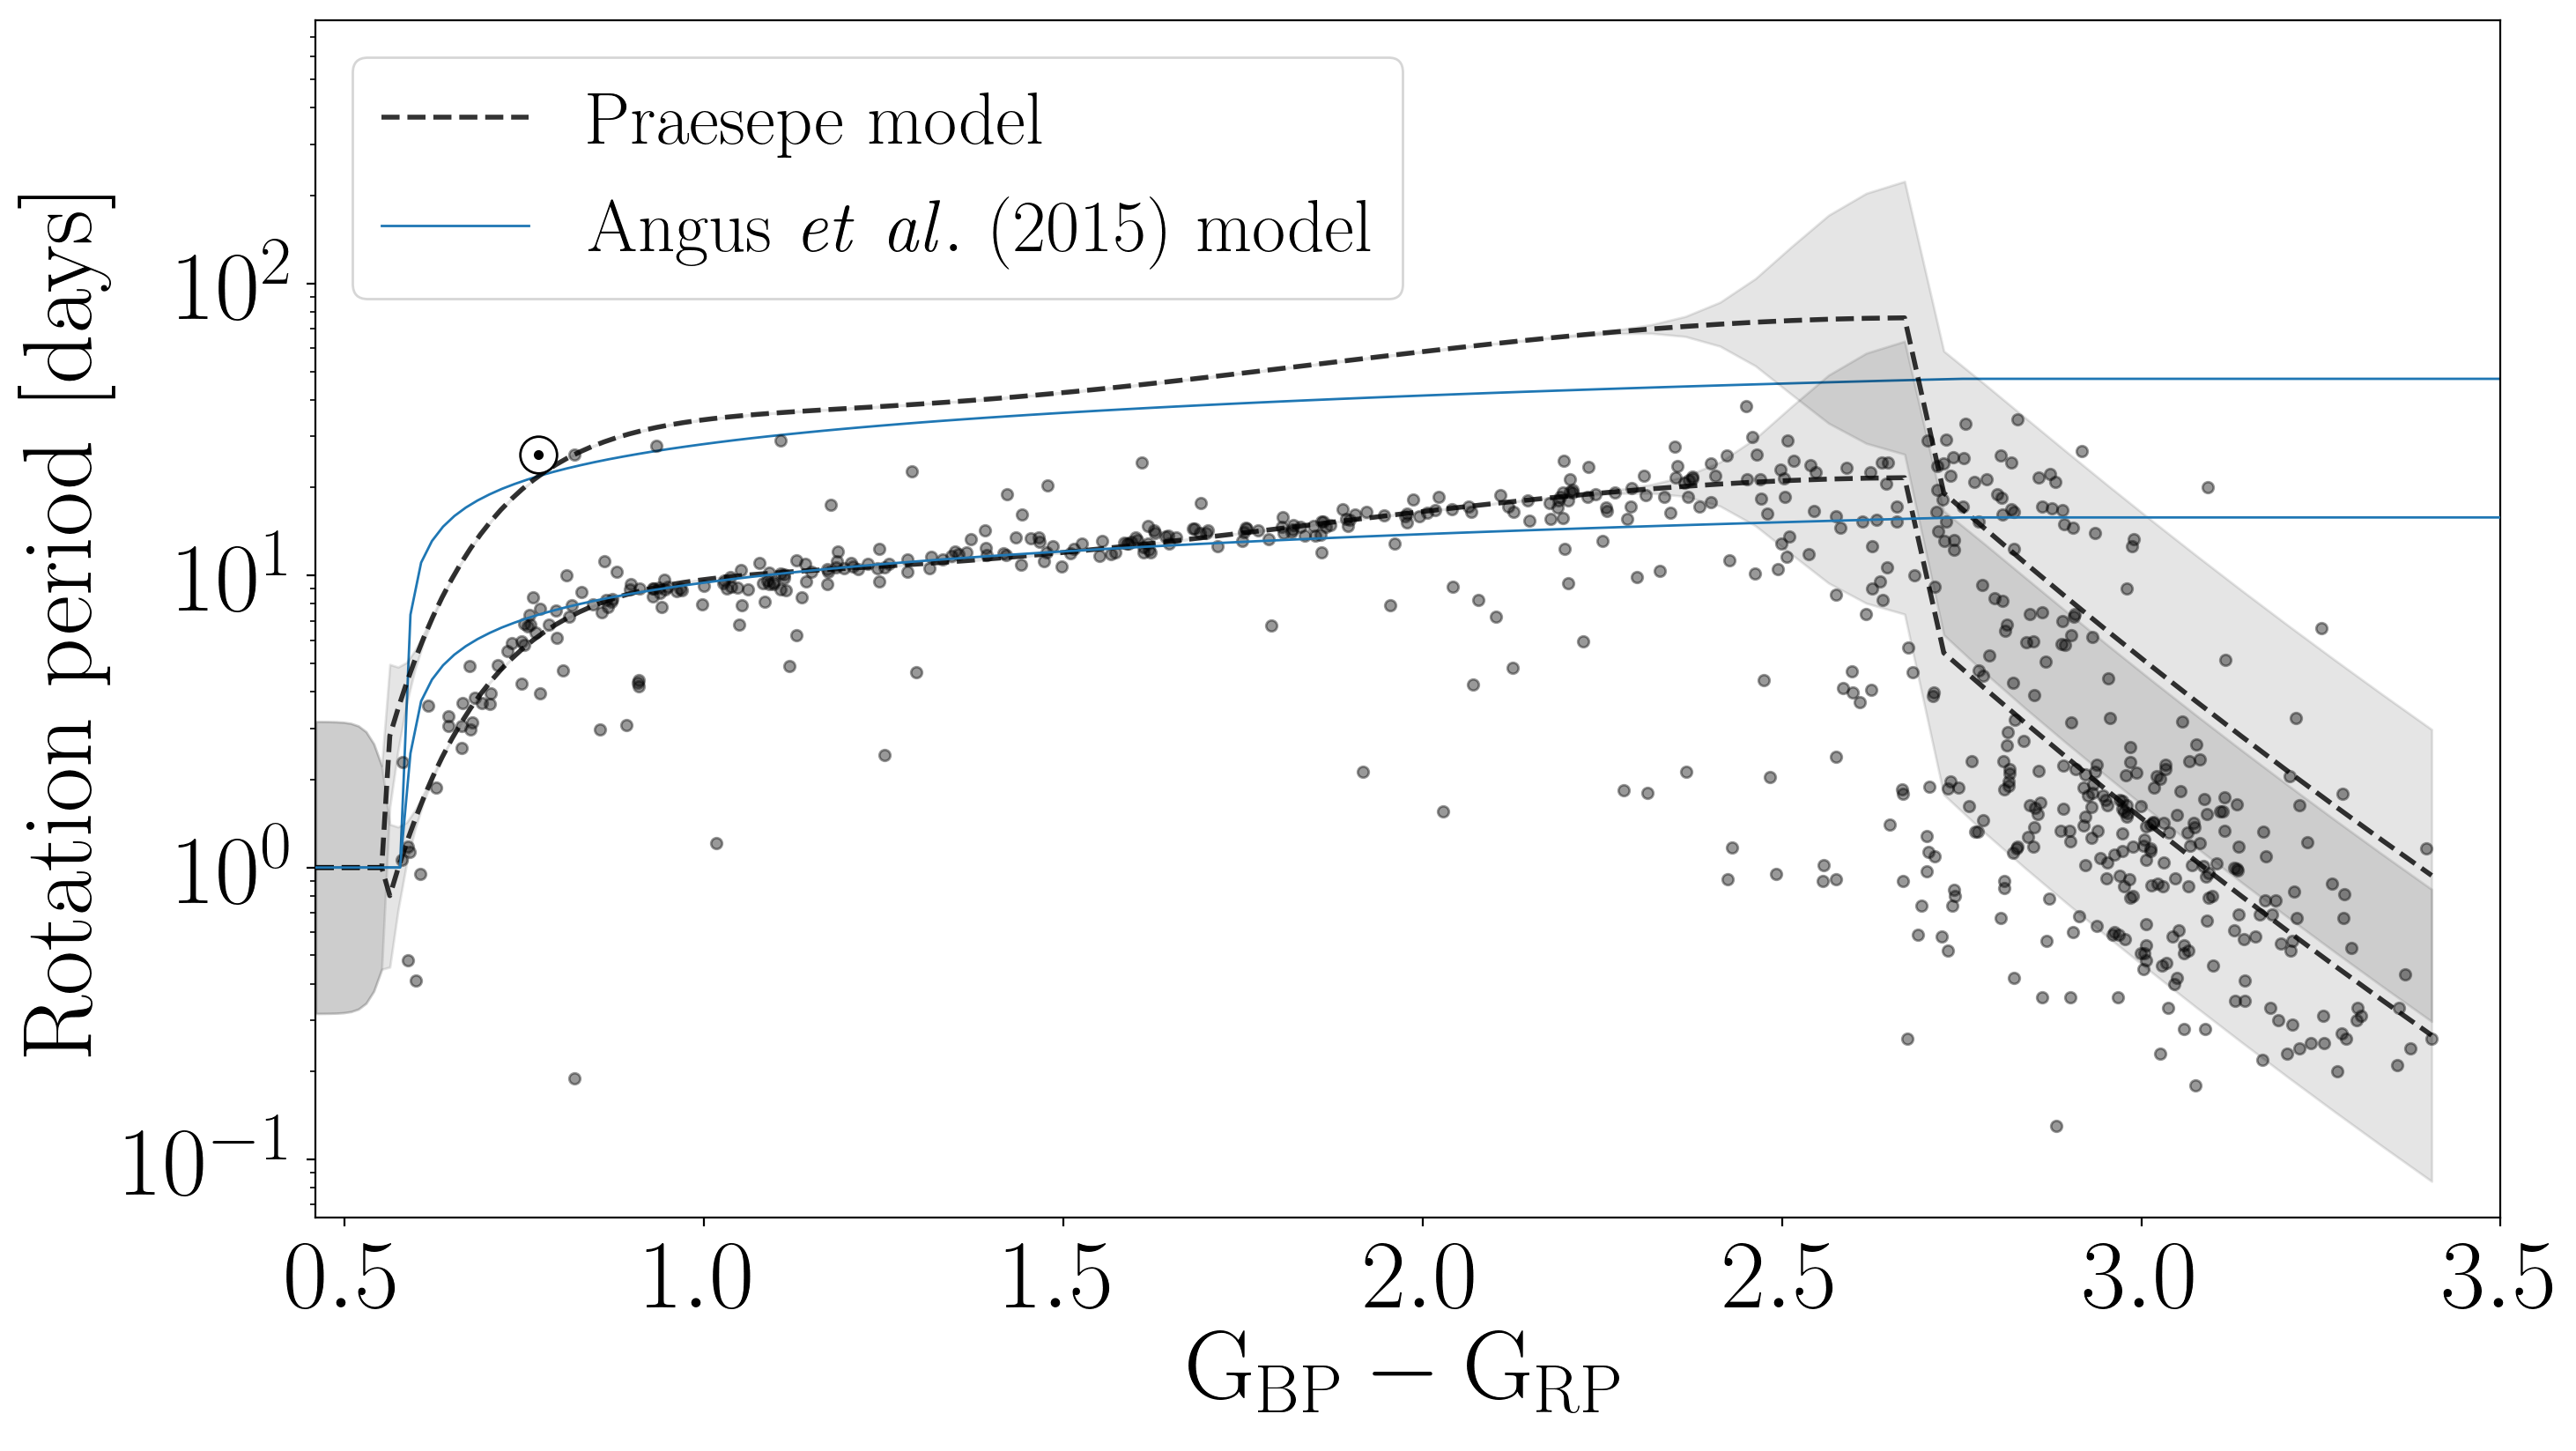

In [144]:
plt.figure(figsize=(16, 9), dpi=200)
plt.plot(10**logbprp_sun, 10**logp_sun, "k.", ms=9, zorder=1, alpha=.4)

mean = bpl_model(bpl_result.x, xplot, np.ones_like(xplot)*np.log10(4.56*1e9))
plt.plot(10**xplot, 10**mean, lw=2, zorder=2, color="k", ls="--", alpha=.8, rasterized=True)
plt.fill_between(10**xplot, 10**(mean - sigma), 10**(mean + sigma), color="k", alpha=.1, rasterized=True)

mean = bpl_model(bpl_result.x, xplot, np.ones_like(xplot)*np.log10(650*1e6))
plt.fill_between(10**xplot, 10**(mean - sigma), 10**(mean + sigma), color="k", alpha=.1, rasterized=True)
plt.plot(10**xplot, 10**mean, lw=2, color="k", ls="--", alpha=.8, rasterized=True,
        label="$\mathrm{Praesepe~model}$")

# plt.plot(10**sun_color, 10**sun_prot, "wo", markeredgecolor="k", ms=15, zorder=2, rasterized=True)
# plt.plot(10**sun_color, 10**sun_prot, ".k", zorder=2, rasterized=True)
plt.plot(.77, 10**sun_prot, "wo", markeredgecolor="k", ms=15, zorder=2, rasterized=True)
plt.plot(.77, 10**sun_prot, ".k", zorder=2, rasterized=True)

plt.xlim(10**(min(xplot)), 3.5)
plt.ylim(10**-1.2, 10**2.9)

plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
plt.yscale("log")

# Add Angus (2015) model
def bv_2_bprp(bv):
    """
    Numbers from https://arxiv.org/pdf/1008.0815.pdf
    """
    a, b, c, d = .0981, 1.4290, -.0269, .0061  # sigma = .43
    return a + b*bv + c*bv**2 + d*bv**3


def bprp_2_bv(bprp):
    """
    Try to find the analytic version of this, please!
    """
    bv_iter = np.linspace(0., 2., 10000)
    bprp_pred = [bv_2_bprp(bv) for bv in bv_iter]
    diffs = bprp - np.array(bprp_pred)
    return bv_iter[np.argmin(diffs**2)]

import stardate.lhf as sdl

xs = np.linspace(-.25, .6, 100)
bv, log_periods_praesepe, log_periods_sun, log_sigs = [np.zeros_like(xs) for i in range(4)]
for i, _x in enumerate(xs):
    bv[i] = bprp_2_bv(10**_x)
    log_periods_praesepe[i] = sdl.gyro_model(np.log10(625*1e6), bv[i])
    log_periods_sun[i] = sdl.gyro_model(np.log10(4.56*1e9), bv[i])
    log_sigs[i] = sdl.sigma(bv[i], 355)
    
plt.plot(10**xs-.15, 10**log_periods_praesepe, color="C0", lw=1, zorder=3, ms=35, rasterized=True)
plt.plot(10**xs-.15, 10**log_periods_sun, color="C0", lw=1, zorder=0, rasterized=True,
         label="$\mathrm{Angus~{\it et~al.}~(2015)~model}$")

plt.legend(loc="upper left")
plt.savefig("../praesepe.pdf")

In [143]:
import stardate.lhf as sdl
print(10**sdl.gyro_model_praesepe(np.log10(4.56*1e9), .82))

25.98136488222407
